<a href="https://colab.research.google.com/github/Khamphang/test-repositry/blob/master/1_notmnist_na.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Deep Learning
=============

Assignment 1
------------

The objective of this assignment is to learn about simple data curation practices, and familiarize you with some of the data we'll be reusing later.

This notebook uses the [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) dataset to be used with python experiments. This dataset is designed to look like the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, while looking a little more like real data: it's a harder task, and the data is a lot less 'clean' than MNIST.

In [0]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
### ຄຳຕອບຂອງ Assignment ນີ້: http://www.ritchieng.com/machine-learning/deep-learning/tensorflow/notmnist/

from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

###   ຖ້າໜ້າແຖວມີ ### ແມ່ນແຖວນັ້ນນາເພີ່ມໃສ່  
np.set_printoptions(precision=2)
###import pdb
###  import pdb; pdb.set_trace()   ###   ນາ    ####
###   ນາເພີ່ມໃສ່     ####

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

First, we'll download the dataset to our local machine. The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labelled examples. Given these sizes, it should be possible to train models quickly on any machine. 

ບໍ່ຮູ້ວ່າຫຼັງຈາກ download ແລ້ວມັນໄປຢູ່ບ່ອນໃດຂອງ notebook ນີ້

In [0]:
url = 'http://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_root = '.' # Change me to store data elsewhere

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 5% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
## Na ## def maybe_download(filename, expected_bytes, force=True):
  """Download a file if not present, and make sure it's the right size."""
  dest_filename = os.path.join(data_root, filename)
  if force or not os.path.exists(dest_filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(dest_filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', dest_filename)
  else:
    raise Exception(
      'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
  return dest_filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified ./notMNIST_large.tar.gz
Found and verified ./notMNIST_small.tar.gz


Extract the dataset from the compressed .tar.gz file.
This should give you a set of directories, labelled A through J.

In [0]:
num_classes = 10
np.random.seed(133)   ## 133 ໝາຍເຖິງຫຍັງນໍ ??? An array of random numbers in the [0.0, 1.0]

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall(data_root)
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))         # The method len() returns the number of elements in the list
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)    # train_folders ເປັນ array ເກັບທີ່ຢູ່ຂອງຮູບຕາມແຕ່ລະໂຕອັກສອນ ເຊັ່ນ:'./notMNIST_large/D'
test_folders = maybe_extract(test_filename)

./notMNIST_large already present - Skipping extraction of ./notMNIST_large.tar.gz.
['./notMNIST_large/A', './notMNIST_large/B', './notMNIST_large/C', './notMNIST_large/D', './notMNIST_large/E', './notMNIST_large/F', './notMNIST_large/G', './notMNIST_large/H', './notMNIST_large/I', './notMNIST_large/J']
./notMNIST_small already present - Skipping extraction of ./notMNIST_small.tar.gz.
['./notMNIST_small/A', './notMNIST_small/B', './notMNIST_small/C', './notMNIST_small/D', './notMNIST_small/E', './notMNIST_small/F', './notMNIST_small/G', './notMNIST_small/H', './notMNIST_small/I', './notMNIST_small/J']


---
Problem 1
---------

Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded. Hint: you can use the package IPython.display.

---

In [0]:
# We get all file names in I directory
fn = os.listdir("notMNIST_small/I/")

# Display first 1 images of I directory
for file in fn[:1]:
    path = 'notMNIST_small/I/' + file
    display(Image(path))

In [0]:
# Display first 8 images ສະແດງ 8ໂຕທຳອິດ
for file in fn[:8]:
    path = 'notMNIST_small/I/' + file
##    print (path)
    display(Image(path))

###   ນາເພີ່ມໃສ່  ###
###    import pdb; pdb.set_trace()

In [0]:
###   ນາເພີ່ມໃສ່   ເພື່ອຊອກຈຳນວນຟ້າຍໃນ ໂຟນເດີ(ໄດເລັກໂຕຣີ) ###
# list = os.listdir(fn) # fn is your directory path
dir = os.listdir("notMNIST_large/D/")
number_files = len(dir)
print ('ຈຳນວນຮູບໃນໂຟນເດີ [notMNIST_large/D/]: ',number_files,'ຮູບ')

ຈຳນວນຮູບໃນໂຟນເດີ [notMNIST_large/D/]:  52912 ຮູບ


In [0]:
print(test_folders)
display(Image(path))
image_file = path
image_data_Na = ndimage.imread(image_file).astype(float)
print(image_data_Na) ### ເບິ່ງຄ່າແຕ່ລະພິເຊວກ່ອນເປັນ zero mean and standard deviation ~0.5 to make training easier down the road

pixel_depth_Na = 255.0  # Number of levels per pixel.
image_data_Na = (image_data_Na - pixel_depth_Na / 2) / pixel_depth_Na
print(image_data_Na) ### ເບິ່ງຄ່າແຕ່ລະພິເຊວເມື່ອປ່ຽນເປັນ zero mean and standard deviation ~0.5 to make training easier down the road

['./notMNIST_small/A', './notMNIST_small/B', './notMNIST_small/C', './notMNIST_small/D', './notMNIST_small/E', './notMNIST_small/F', './notMNIST_small/G', './notMNIST_small/H', './notMNIST_small/I', './notMNIST_small/J']


[[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    1.   2.   4.   3.   0.   0.   0.   0.  28.  86. 158. 222. 249. 176.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   2.   4.
    0.   0.   0.   0.  12.  58. 122. 186. 235. 255. 255. 255. 255. 255.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    1.  39. 100. 168. 224. 255. 255. 255. 255. 253. 252. 254. 255. 247.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  65. 143.
  205. 251. 255. 255. 255. 254. 251. 252. 254. 255. 255. 255. 255. 240.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. 106. 255.
  255. 255. 252. 252. 253. 255. 255. 255. 255. 255. 255. 255. 255. 230.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. 200.
  253. 254. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 219.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. 120.
  255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  after removing the cwd from sys.path.


Now let's load the data in a more manageable format. Since, depending on your computer setup you might not be able to fit it all in memory, we'll load each class into a separate dataset, store them on disk and curate them independently. Later we'll merge them into a single dataset of manageable size.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road. 

A few images might not be readable, we'll just skip them.

..... ໝາຍເຫດ .....: os.listdir(folder) ໝາຍເຖິງຊື່ file ທັງໝົດທີ່ມີຢູ່ໃນໂຟເດີ ຕາມທີ່ຢູ່ທີ່ບອກດ້ວຍຕົວປ່ຽນ "folder"

In [0]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)                              # ໂລດຊື່ file ທັງໝົດທີ່ມີຢູ່ໃນໂຟເດີ (folder) ໃສ່ image_files
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)                      # np.ndarray ແມ່ນປ່ຽນຮູບທັງໝົດເປັນຕົວປ່ຽນ tuple ໂຕດ່ຽວ
  print('ຂະໜາດ dataset ກ່ອນຂັດຮູບໃຊ້ບໍ່ໄດ້ອອກ: ', dataset.shape)     ###   ແຖວນີ້ນາເພີ່ມໃສ່
  print(folder)
  
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:                                                         # ຂັ້ນຕອນນີ້ພະຍາມອ່ານຟ້າຍຮູບຖ້າອ່ານບໍ່ໄດ້ກໍ່ຈະຂັດອອກ
      image_data = (ndimage.imread(image_file).astype(float) -   # ຂັ້ນຕອນນີ້ຄິດວ່າແມ່ນ່ປ່ຽນຮູບຕົວເລກແຕ່ລະພິກເຊວຮູບເປັນຮູບແບບ zero mean and standard deviation ~0.5
                    pixel_depth / 2) / pixel_depth               # to make training easier down the road ເພື່ອງ້າຍໃນການປະຜົນຂອງຄອມ
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
  dataset = dataset[0:num_images, :, :]     ### ແຖວນີ້ອັບເດດຈຳນວນຮູບຫຼັງຈາກຄັດຮູບທີ່ໃຊ້ບໍ່ໄດ້ອອກແລະຈັດລຽນຮູບເຂົ້າມາພ້ອມແລ້ວ
                                            ### ເພື່ອຂະໜາດຂອງອາເລເທົ່າຈຳນວນຮູບທີ່ໃຊ້ໄດ້
###   171224 ນາ    ####

  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))           ### ???
  print('Standard deviation:', np.std(dataset))   ### ???
  return dataset

###   171225 ນາ    ####

def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:                               # ຮອບທຳອິດ ເອົາຄ່າຫ້ອງທີ່1 ຂອງອາເລ້ data_folders ໃສ່ folder ຮອບຕໍ່ໄປກໍ່ເອົາຫ້ອງໄປຕໍ່ໄປຈົນຮອດສຸດທ້າຍ
    set_filename = folder + '.pickle'                       # ເຊັນ './notMNIST_large/A', './notMNIST_large/B', ...
    dataset_names.append(set_filename)                      # ລວມທີ່ຢູ່ພ້ອມຊື່ຟ້າຍນາມສະກຸນ .pickle ຂອງແຕ່ລະຕົວອັກສອນໃສ່ dataset_names ເພື່ອ
    if os.path.exists(set_filename) and not force:          # ຫຼັງເປັນຮູບເປັນຮູບເປັນຟ້າຍ .pickle ກໍ່ return ພຽງທີ່ຢູ່ພ້ອມຊື່
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class) # ແຖວນີ້ໂລດກຸ່ມຮູບໃສ່ອາເລໂຕດຽວເພື່ອໄວ້ປ່ຽນເປັນຟ້າຍ .pickle
      try:
        with open(set_filename, 'wb') as f:                  #  ເປີດຟາຍຕາມ set_filename ໃນແບບ 'wb' ເປັນໄບນາລີແລະສາມາດຂຽນໃສ່ຟາຍໄດ້
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)   # ແຖວນີ້ປ່ຽນອາເລເປັນຟ້າຍ .pickle  ຕົວຢ່າງ A.pickle
      except Exception as e:                                 # ຕົວຢ່າງຂອງ pickle.dump ຢູ່ https://kite.com/docs/python;pickle.dump
        print('Unable to save data to', set_filename, ':', e)       
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

###   171229 ນາ    ####

./notMNIST_large/A.pickle already present - Skipping pickling.
./notMNIST_large/B.pickle already present - Skipping pickling.
./notMNIST_large/C.pickle already present - Skipping pickling.
./notMNIST_large/D.pickle already present - Skipping pickling.
./notMNIST_large/E.pickle already present - Skipping pickling.
./notMNIST_large/F.pickle already present - Skipping pickling.
./notMNIST_large/G.pickle already present - Skipping pickling.
./notMNIST_large/H.pickle already present - Skipping pickling.
./notMNIST_large/I.pickle already present - Skipping pickling.
./notMNIST_large/J.pickle already present - Skipping pickling.
./notMNIST_small/A.pickle already present - Skipping pickling.
./notMNIST_small/B.pickle already present - Skipping pickling.
./notMNIST_small/C.pickle already present - Skipping pickling.
./notMNIST_small/D.pickle already present - Skipping pickling.
./notMNIST_small/E.pickle already present - Skipping pickling.
./notMNIST_small/F.pickle already present - Skipping pi

---
Problem 2
---------

Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray. Hint: you can use matplotlib.pyplot.

---

[[-0.5  -0.5  -0.5  -0.5  -0.5  -0.5  -0.5  -0.5  -0.5  -0.5  -0.5  -0.5
  -0.5  -0.5  -0.5  -0.5  -0.5  -0.5  -0.5  -0.5  -0.5  -0.5  -0.5  -0.49
  -0.5  -0.39  0.26  0.1 ]
 [-0.5  -0.5  -0.5  -0.5  -0.5  -0.5  -0.5  -0.5  -0.5  -0.5  -0.5  -0.5
  -0.5  -0.5  -0.5  -0.5  -0.5  -0.5  -0.5  -0.49 -0.49 -0.5  -0.5  -0.5
  -0.22  0.31  0.04 -0.45]
 [-0.5  -0.5  -0.5  -0.5  -0.5  -0.5  -0.5  -0.5  -0.5  -0.5  -0.5  -0.5
  -0.5  -0.5  -0.5  -0.5  -0.49 -0.49 -0.5  -0.5  -0.5  -0.42 -0.34 -0.14
  -0.06 -0.36 -0.5  -0.5 ]
 [-0.5  -0.5  -0.5  -0.5  -0.5  -0.5  -0.5  -0.5  -0.5  -0.5  -0.5  -0.5
  -0.5  -0.5  -0.5  -0.49 -0.5  -0.5  -0.41 -0.14  0.02 -0.11 -0.09 -0.19
  -0.5  -0.5  -0.49 -0.5 ]
 [-0.5  -0.5  -0.5  -0.5  -0.5  -0.5  -0.5  -0.5  -0.5  -0.5  -0.5  -0.5
  -0.5  -0.5  -0.5  -0.5  -0.27  0.17  0.31  0.04 -0.31 -0.36 -0.11 -0.5
  -0.48 -0.49 -0.5  -0.5 ]
 [-0.5  -0.5  -0.5  -0.5  -0.5  -0.5  -0.5  -0.5  -0.5  -0.5  -0.5  -0.5
  -0.5  -0.5  -0.43  0.17  0.5   0.19 -0.37 -0.5  -0.5   0.

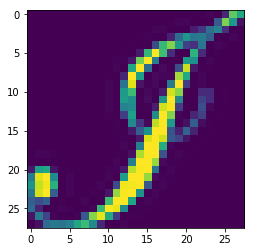

In [0]:
# index 0 should be all As, 1 = all Bs, etc. ອິນເດັດ(Index ຫຼື Label) 0 ໝາຍເຖິງກຸ່ມຕົວອັກສອນ 'A', ອິນເດັດ 1 ໝາຍເຖິງ  'B'
pickle_file = train_datasets[8]  

# With would automatically close the file after the nested block of code
with open(pickle_file, 'rb') as f:
    
    # unpickle
    letter_set = pickle.load(f)  
    
    # pick a random image index
    sample_idx = np.random.randint(len(letter_set))      # The method len() returns the number of elements in the list
                                                         # ຊຸ່ມເອົາເລກໃດໜຶ່ງ ແຕ່ 0 ຫາ len(letter_set) ກໍ່ຄືຊຸມເອົາຮູບໃດໜຶ່ງໃນ train_datasets[8]
    # extract a 2D slice    ບໍ່ເຂົ້າໃຈຄຳອະທິີບາຍແຖວນີ້ ???
    sample_image = letter_set[sample_idx, :, :] 

    ## sample_image = letter_set[7, :, :]          # ຖ້າບໍ່ຢາກຊຸມກໍ່ໃຊ້ແຖວນີ້

    plt.figure()
    
    # display it ສະແດງຮູບເພື່ອກວດເບິ່ງວ່າຮູບທີ່ໄດ້ມາມັນດີບໍ່
    plt.imshow(sample_image)
                    
    print(sample_image)   # ເປັນຫຍັງຕົວເລກພວກນີ້ມີຄ່າດຽວຢູ່ໃນພິກເຊວເມື່ອສ້າງເປັນຮູບຄືບໍ່ເປັນຮູບຂາວດຳ

---
Problem 3
---------
Another check: we expect the data to be balanced across classes. Verify that. 'balanced across classes' ບໍ່ຮູ້ໝາຍເຖິງຫຍັງ

---

Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune `train_size` as needed. The labels will be stored into a separate array of integers 0 through 9.

Also create a validation dataset for hyperparameter tuning.

Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.
ທີ່ຜ່ານມາໄດ້ shuffle ຮູບໃນແຕ່ລະກຸ່ມຕົວອັກສອນ ແລ້ວຈຶ່ງໂລດໃສ່ valid_dataset, valid_labels, train_dataset, train_labels, test_dataset, ແລະ test_labels ເມື່ອໂລດໃສ່ແລ້ວພວກມັນຍັງແຍກເປັນຊັ້ນແຕ່ລະຕົວອັກສອນ ສະນັ້ນເພື່ອໃຫ້ໃກ້ກັບຕົວຈິງຫຼາຍຂື້ນກໍ່ຕ້ອງ random ລຳດັບທັງ່ໝົດໃໝ່ໝົດຂອງ valid_dataset, valid_labels, train_dataset, train_labels, test_dataset, ແລະ test_labelsໂດຍການຈັບຄູ່ຂອງຂໍ້ມູນ ແລະ ລາບິວຂອງຖືກຄູ່ກັນຢູ່

In [0]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):    # ສຳລັບຄ່າ valid_size=0 ມັນຈະເທົ່າ 0 ຖ້າໂຕເອີ້ນຟັງຊັນນີ້ບໍ່ໃຫ້ຄ່າ valid_size  
# ຟັງຊັນນີ້ລວມ
## ອະທິບາຍໂຕຫຍໍ້ _v ໝາຍເຖິງ _validation, _t ໝາຍເຖິງ _training ແລະ _l ໝາຍເຖິງ All ຄືຈຳນວນ _v + _t: end_l = vsize_per_class+tsize_per_class
    
  num_classes = len(pickle_files)                              # ເອົາເລກທີ່ເທົ່າກັບຈຳນວນຟ້າຍໃນ ໂຟນເດີທີ່ກຳນົດມາ ''
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):     # enumerate ສ້າງເລກລຳດັບຈັບຄູ່ກັບແຕ່ລະອົງປະກອບ ກໍ່ຄືລຳດັບ 0 ແທນໃຫ້ອົງປະກອບທຳອິດ
    try:                                                 # ໝາຍຄວາມວ່າລຳດັບ 0 ແທນໃຫ້ຕົວອັກສອນ A ເພາະ A ແມ່ນອົງປະກອບທຳອິດຂອງ pickle_files
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random  and training set
        np.random.shuffle(letter_set)          # shuffle ເຮັດໃຫ້ຈັດລຳດັບໃໝ່ແບບຊຸ່ມເດົາ ຂອງແຕ່ລະກຸ່ມຕົວອັກສອນໃຜມັນ ຕົວຢ່າງ https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.random.shuffle.html
        
        # ຫຼັງຈາກຈັດລຳດັບໃໝ່ແບບຊຸ່ມເດົາແລ້ວຈຶ່ງປ້ອນຮູບໃສ່  valid_dataset ແລະ ໃສ່ train_dataset ໂດຍເອົາໃສ່ຕໍ່ກັນເທື່ອລະກຸ່ມຕົວອັກສອນ
        # ແລ້ວກໍ່ຈະໄດ້ valid_dataset, valid_labels, train_dataset, train_labels ທີ່ມີທຸກຕົວອັກສອນ ພ້ອມລຽນລຳດັບຈັບຄູ່ກັບ label ຂອງມັນເອງ
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]    
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
###  print('label :', label)
###  print('vsize_per_class: ',vsize_per_class)
  return valid_dataset, valid_labels, train_dataset, train_labels
            
train_size = 20000       # ຂະໜາດຈາກ ຕົວຢ່າງເຂົາເຈົ້າ
valid_size = 10000
test_size = 10000
  
## train_size = 2000 * 4  # ເນື່ອງຈາກຈຳນວນຝຶກແອບມີຮອດປະມານ 500000ໂຕ ແຕ່ຄອມຂ້ອຍສາມາດຝຶກແອບໄດ້ປະມານພຽງ 10000 ໂຕຝຶກແອບ
## valid_size = 150 * 4   # ຂະໜາດຂໍ້ມູນທີ່ໃຊ້ທົດລອງ
## test_size = 100 * 4

# ຄຳສັ່ງແຖວຂ້າງລູ່ມນີ້ເລືອກເອົາບັນດາຕົວຝຶກແອບອອກເປັນ 2ກຸ່ມຄື: ກຸ່ມຝຶກແອບ ແລະ ກຸ່ມທົດລອງ ຕາມກຳນົດຂ້າງເທິງ ໂດຍເລືອກເອົາແບບຊຸ່ມເອົາ 'shuffle'
valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)         

_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (20000, 28, 28) (20000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


In [0]:
def randomize(dataset, labels):    
  permutation = np.random.permutation(labels.shape[0])   # ເປັນຄຳສັງສະລັບລຳດັບຂອງອົງປະກອບແບບຊຸມ ໃນແຖວນີ້ຈະສະລັບເລກລຳດັບແຕ່ 0 ຫາ ລຳດັບໃຫຍ່ສຸດ
                                                         # ຂອງ labels ກໍ່ຄືເລກ labels.shape[0]
                                                         # np.random.permutation() Randomly permute a sequence, or return a permuted range.
                                                         # If x is a multi-dimensional array, it is only shuffled along its first index.
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

---
Problem 4
---------
Convince yourself that the data is still good after shuffling!

---

Finally, let's save the data for later reuse:

In [0]:
pickle_file = os.path.join(data_root, 'notMNIST.pickle')     # ຟາຍ 'notMNIST.pickle' ເຮັດໜ້າທີ່ເກັບຂໍ້ມູນທັງໝົດໃຊ້ໃຫ້ຄອມຮຽນຮູ້ຕົວອັກສອນ
                                                             # ເຊິ່ງຂໍ້ມູນນັ້ນເປັນໄບນາລີ ຢູ່ໃນຕົວປ່ຽນແບບ array
try:
  f = open(pickle_file, 'wb') 
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [0]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)        ### ບໍ່ຮູ້ຕົວເລກທີ່ມັນສະແດງອອກມາແມ່ນຫົວໜ່ວຍຫຍັງ

###   180101 ນາ    ####

Compressed pickle size: 125600502


---
Problem 5
---------

By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it.
Measure how much overlap there is between training, validation and test samples.

Optional questions:
- What about near duplicates between datasets? (images that are almost identical)
- Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.
---

In [0]:
import time

def check_overlaps(images1, images2):
    images1.flags.writeable=False
    images2.flags.writeable=False
    start = time.clock()
    hash1 = set([hash(image1.tobytes()) for image1 in images1])
    hash2 = set([hash(image2.tobytes()) for image2 in images2])
    all_overlaps = set.intersection(hash1, hash2)
    return all_overlaps, time.clock()-start

r, execTime = check_overlaps(train_dataset, test_dataset)    
print('Number of overlaps between training and test sets: {}. Execution time: {}.'.format(len(r), execTime))

r, execTime = check_overlaps(train_dataset, valid_dataset)   
print('Number of overlaps between training and validation sets: {}. Execution time: {}.'.format(len(r), execTime))

r, execTime = check_overlaps(valid_dataset, test_dataset) 
print('Number of overlaps between validation and test sets: {}. Execution time: {}.'.format(len(r), execTime))

Number of overlaps between training and test sets: 129. Execution time: 0.07697800000000399.
Number of overlaps between training and validation sets: 125. Execution time: 0.07509499999999747.
Number of overlaps between validation and test sets: 80. Execution time: 0.051186000000001286.


---
Problem 6
---------

Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from sklearn.linear_model.

Optional question: train an off-the-shelf model on all the data!

---

In [0]:
# Here you have 200000 samples
# 28 x 28 features
# We have to reshape them because scikit-learn expects (n_samples, n_features)
train_dataset.shape

###  print(train_dataset)
###  display(train_dataset)

(20000, 28, 28)

In [0]:
### test_dataset.shape

### print(test_dataset)

In [0]:
# Prepare training data
samples, width, height = train_dataset.shape
X_train = np.reshape(train_dataset,(samples,width*height))
y_train = train_labels

# Prepare testing data
samples, width, height = test_dataset.shape
X_test = np.reshape(test_dataset,(samples,width*height))
y_test = test_labels

In [0]:
# Import
from sklearn.linear_model import LogisticRegression

# Instantiate
lg = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=42, verbose=1, max_iter=1000, n_jobs=-1)

# Fit
lg.fit(X_train, y_train)   ###---     ແຖວນີ້ໜ້າຈະແມ່ນຄຳສັ່ງໃຫ້ຮຽນ       ---###

# Predict
y_pred = lg.predict(X_test)   ###--- ຫຼັງຈາກຮຽນແລ້ວກໍ່ມາທົດສອບກັບຊຸດຂໍ້ມູນ X_test ຊຶ່ງຜົນການທົດສອບເກັບໄວ້ຢູ່ y_pred       ---###

# Score
from sklearn import metrics
metrics.accuracy_score(y_test, y_pred)    ###--- ຫຼັງຈາກທົດສອບແລ້ວກໍ່ມາເບິ່ງຄວາມແນ່ນອນໂດຍທຽບກັນລະຫວ່າງ y_test ກັບ  y_pred     ---###

###   180106 ນາ    ####

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  1.9min finished


0.8706

In [0]:
###   180603 ສືກສາຄືນເປັນຄັ້ງທີ່ 2  ຜົນໄດ້ຮັບໂອກາດແທ້ຕ້ອງແມ່ນ 86.79999999%  ####

190505

Training: (10000, 28, 28) (10000,)
Validation: (750, 28, 28) (750,)
Testing: (500, 28, 28) (500,)

ໃຊ້ CPU ຜົນໄດ້ຮັບ  0.862(86.2%)     ໃຊ້ເວລາ 55.4ວິນາທີ
ໃຊ້ GPU ຜົນໄດ້ຮັບ  0.89                     ໃຊ້ເວລາ 44.9ວິນາທີ


Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)

ໃຊ້ CPU ຜົນໄດ້ຮັບ 0.8967               ໃຊ້ເວລາ   18.4ນາທີ            physical_device_desc: "device: XLA_CPU device"
ໃຊ້ GPU ຜົນໄດ້ຮັບ 0.898                 ໃຊ້ເວລາ   15.0ນາທີ            physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"

190513

Training: (2000, 28, 28) (2000,)
Validation: (100, 28, 28) (100,)
Testing: (100, 28, 28) (100,)

ໃຊ້ GPU ຜົນໄດ້ຮັບ  0.91                     ໃຊ້ເວລາ 4.8ວິນາທີ           device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"

In [0]:
from tensorflow.python.client import device_lib

print("Show System RAM Memory:\n\n")
!cat /proc/meminfo | egrep "MemTotal*"


print("\n\nShow Devices:\n\n"+str(device_lib.list_local_devices()))

Show System RAM Memory:


MemTotal:       13335276 kB


Show Devices:

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16593627012603451371
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 15155033005929938110
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 2176074872748532414
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14800692839
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13397765561266269658
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]
